# IMPORTS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')

plt.style.use('ggplot')
sns.set_palette("deep")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thebiggestnutcase/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/thebiggestnutcase/nltk_data...


# Load Data

In [6]:
courses = pd.read_csv("Dataset/Coursera_courses.csv")
reviews = pd.read_csv("Dataset/Coursera_reviews.csv")

In [10]:
courses.head()

,name,institution,course_url,course_id
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning
1,Indigenous Canada,University of Alberta,https://www.coursera.org/learn/indigenous-canada,indigenous-canada
2,The Science of Well-Being,Yale University,https://www.coursera.org/learn/the-science-of-...,the-science-of-well-being
3,Technical Support Fundamentals,Google,https://www.coursera.org/learn/technical-suppo...,technical-support-fundamentals
4,Become a CBRS Certified Professional Installer...,Google - Spectrum Sharing,https://www.coursera.org/learn/google-cbrs-cpi...,google-cbrs-cpi-training


In [11]:
courses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623 entries, 0 to 622
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         623 non-null    object
 1   institution  623 non-null    object
 2   course_url   623 non-null    object
 3   course_id    623 non-null    object
dtypes: object(4)
memory usage: 19.6+ KB


In [9]:
reviews.head()

,reviews,reviewers,date_reviews,rating,course_id
0,"Pretty dry, but I was able to pass with just t...",By Robert S,"Feb 12, 2020",4,google-cbrs-cpi-training
1,would be a better experience if the video and ...,By Gabriel E R,"Sep 28, 2020",4,google-cbrs-cpi-training
2,Information was perfect! The program itself wa...,By Jacob D,"Apr 08, 2020",4,google-cbrs-cpi-training
3,A few grammatical mistakes on test made me do ...,By Dale B,"Feb 24, 2020",4,google-cbrs-cpi-training
4,Excellent course and the training provided was...,By Sean G,"Jun 18, 2020",4,google-cbrs-cpi-training


In [12]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1454711 entries, 0 to 1454710
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   reviews       1454558 non-null  object
 1   reviewers     1454711 non-null  object
 2   date_reviews  1454711 non-null  object
 3   rating        1454711 non-null  int64 
 4   course_id     1454711 non-null  object
dtypes: int64(1), object(4)
memory usage: 55.5+ MB


# Initial Data Cleaning

## Cleaning courses dataset

In [14]:
# Remove duplicates
courses.drop_duplicates(subset="course_id", inplace=True)
courses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623 entries, 0 to 622
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         623 non-null    object
 1   institution  623 non-null    object
 2   course_url   623 non-null    object
 3   course_id    623 non-null    object
dtypes: object(4)
memory usage: 19.6+ KB


In [21]:
# Clean text fields
courses["name"] = courses["name"].str.strip()
courses["institution"] = courses["institution"].str.strip()
courses["name"]

0                                       Machine Learning
1                                      Indigenous Canada
2                              The Science of Well-Being
3                         Technical Support Fundamentals
4      Become a CBRS Certified Professional Installer...
                             ...                        
618                Accounting Data Analytics with Python
619               Introduction to Molecular Spectroscopy
620                                  Managing as a Coach
621               The fundamentals of hotel distribution
622                       A Crash Course in Data Science
Name: name, Length: 623, dtype: object

In [22]:
# Validate course URLs (remove broken ones if needed)
courses["course_url"] = courses["course_url"].str.strip()

In [23]:
courses.isna().sum()

name           0
institution    0
course_url     0
course_id      0
dtype: int64

## Cleaning reviews dataset

In [24]:
# Drop rows with no rating
reviews = reviews.dropna(subset=["rating"])

In [25]:
# Convert rating to numeric (some datasets have them as strings)
reviews["rating"] = pd.to_numeric(reviews["rating"], errors="coerce")
reviews = reviews[reviews["rating"].between(1, 5)]

In [26]:
# Clean reviewer names
reviews["reviewers"] = reviews["reviewers"].astype(str).str.strip()

In [27]:
# Remove reviews that are too short
reviews = reviews[reviews["reviews"].astype(str).str.len() > 3]

In [28]:
# Convert review dates to datetime
reviews["date_reviews"] = pd.to_datetime(reviews["date_reviews"], errors="coerce")

In [30]:
reviews.isna().sum()

reviews         0
reviewers       0
date_reviews    0
rating          0
course_id       0
dtype: int64

# Merge Two Datasets

In [31]:
df = reviews.merge(courses, on="course_id", how="left")

In [33]:
df.shape

(1446604, 8)

In [34]:
df.head()

,reviews,reviewers,date_reviews,rating,course_id,name,institution,course_url
0,"Pretty dry, but I was able to pass with just t...",By Robert S,2020-02-12,4,google-cbrs-cpi-training,Become a CBRS Certified Professional Installer...,Google - Spectrum Sharing,https://www.coursera.org/learn/google-cbrs-cpi...
1,would be a better experience if the video and ...,By Gabriel E R,2020-09-28,4,google-cbrs-cpi-training,Become a CBRS Certified Professional Installer...,Google - Spectrum Sharing,https://www.coursera.org/learn/google-cbrs-cpi...
2,Information was perfect! The program itself wa...,By Jacob D,2020-04-08,4,google-cbrs-cpi-training,Become a CBRS Certified Professional Installer...,Google - Spectrum Sharing,https://www.coursera.org/learn/google-cbrs-cpi...
3,A few grammatical mistakes on test made me do ...,By Dale B,2020-02-24,4,google-cbrs-cpi-training,Become a CBRS Certified Professional Installer...,Google - Spectrum Sharing,https://www.coursera.org/learn/google-cbrs-cpi...
4,Excellent course and the training provided was...,By Sean G,2020-06-18,4,google-cbrs-cpi-training,Become a CBRS Certified Professional Installer...,Google - Spectrum Sharing,https://www.coursera.org/learn/google-cbrs-cpi...


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1446604 entries, 0 to 1446603
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   reviews       1446604 non-null  object        
 1   reviewers     1446604 non-null  object        
 2   date_reviews  1446604 non-null  datetime64[ns]
 3   rating        1446604 non-null  int64         
 4   course_id     1446604 non-null  object        
 5   name          1446604 non-null  object        
 6   institution   1446604 non-null  object        
 7   course_url    1446604 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 88.3+ MB


In [36]:
# Check for missing course data
missing_courses = df[df["name"].isna()]
missing_courses.head()

,reviews,reviewers,date_reviews,rating,course_id,name,institution,course_url


In [37]:
# If missing rows exist
df = df[df["name"].notna()]

# Create Base Course Statistics Dataset

In [39]:
course_stats = df.groupby("course_id").agg(
    review_count    = ("rating", "count"),
    avg_rating      = ("rating", "mean"),
    rating_variance = ("rating", "var"),
    course_name     = ("name", "first"),
    institution     = ("institution", "first")
).reset_index()

course_stats.head()

,course_id,review_count,avg_rating,rating_variance,course_name,institution
0,aboriginal-education,197,4.604061,0.638351,Aboriginal Worldviews and Education,University of Toronto
1,access-control-sscp,122,4.540984,1.093348,Access Controls,(ISC)²
2,accounting-analytics,1341,4.427293,1.086687,Accounting Analytics,University of Pennsylvania
3,accounting-data-analytics-python,24,3.500000,1.304348,Accounting Data Analytics with Python,University of Illinois at Urbana-Champaign
4,actualizacion-manejo-diabetes-tipo-2,515,4.866019,0.209641,Actualización en el manejo del paciente con di...,Universidad Nacional Autónoma de México


In [43]:
course_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604 entries, 0 to 603
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   course_id        604 non-null    object 
 1   review_count     604 non-null    int64  
 2   avg_rating       604 non-null    float64
 3   rating_variance  604 non-null    float64
 4   course_name      604 non-null    object 
 5   institution      604 non-null    object 
dtypes: float64(2), int64(1), object(3)
memory usage: 28.4+ KB


In [40]:
# Filter out unstable courses
filtered = course_stats[course_stats["review_count"] >= 5]

In [42]:
filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 603 entries, 0 to 603
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   course_id        603 non-null    object 
 1   review_count     603 non-null    int64  
 2   avg_rating       603 non-null    float64
 3   rating_variance  603 non-null    float64
 4   course_name      603 non-null    object 
 5   institution      603 non-null    object 
dtypes: float64(2), int64(1), object(3)
memory usage: 33.0+ KB


# EDA

## Rating distribution

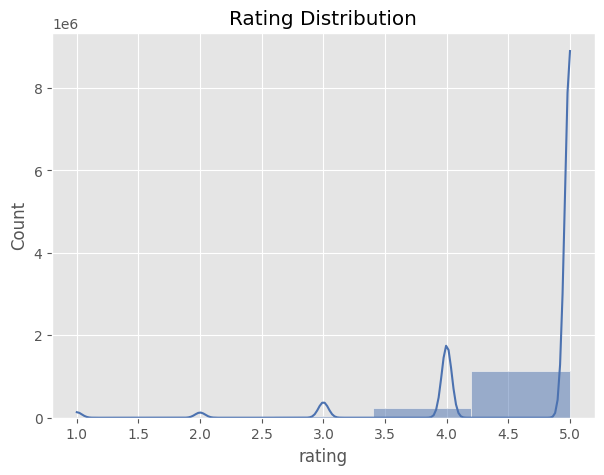

In [97]:
plt.figure(figsize=(7,5))
sns.histplot(df["rating"], bins=5, kde=True)
plt.title("Rating Distribution")
plt.savefig("site/assets/rating_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

## Most-reviewed courses

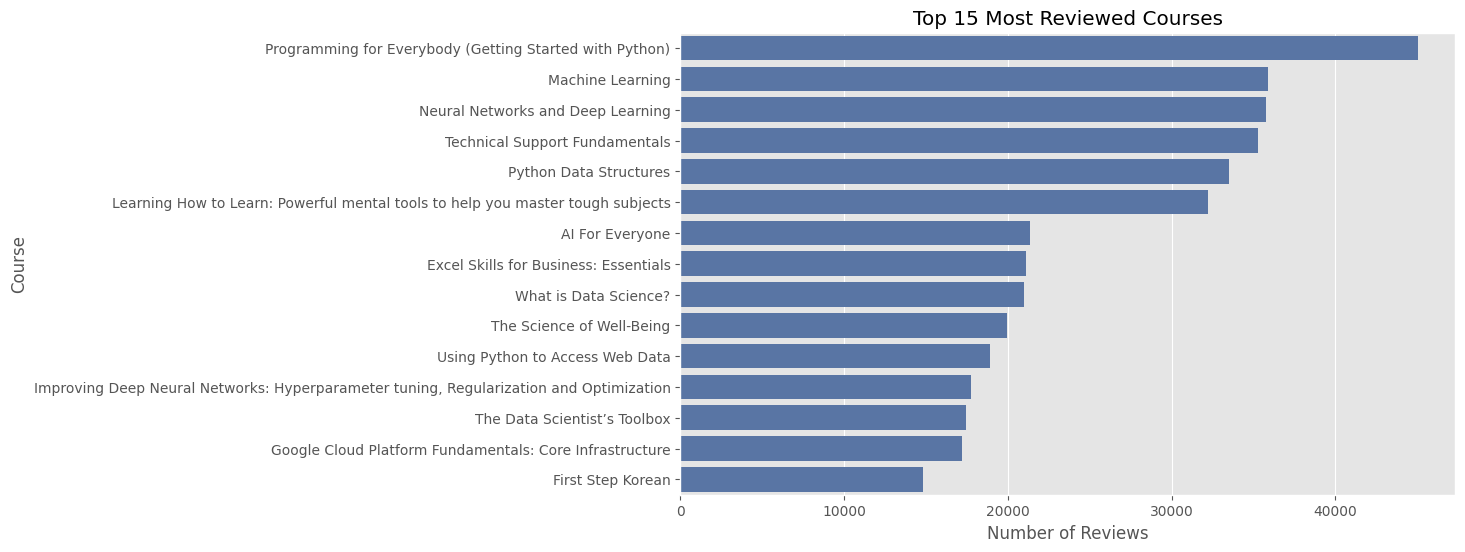

In [98]:
top_courses = filtered.sort_values("review_count", ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(data=top_courses, x="review_count", y="course_name")
plt.title("Top 15 Most Reviewed Courses")
plt.xlabel("Number of Reviews")
plt.ylabel("Course")
plt.savefig("site/assets/top_courses.png", dpi=300, bbox_inches="tight")
plt.show()

## Popularity vs Average Rating

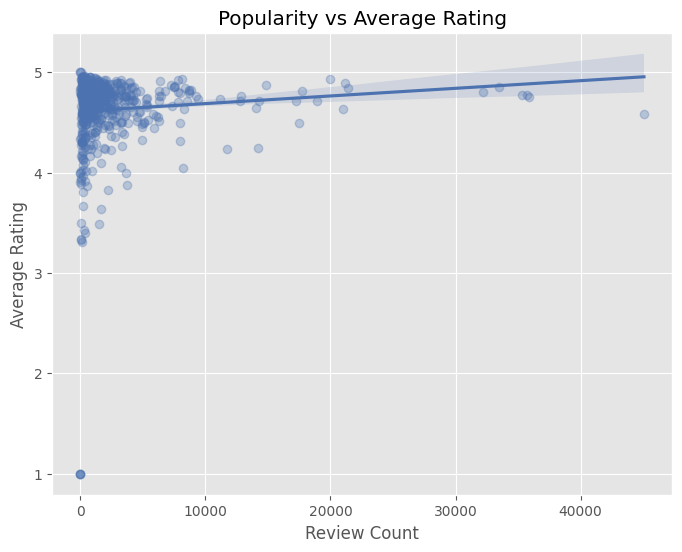

In [99]:
plt.figure(figsize=(8,6))
sns.regplot(data=filtered, x="review_count", y="avg_rating",
            scatter_kws={"alpha":0.3})
plt.title("Popularity vs Average Rating")
plt.xlabel("Review Count")
plt.ylabel("Average Rating")
plt.savefig("site/assets/popularity_avg_rating.png", dpi=300, bbox_inches="tight")
plt.show()

## Popularity vs Rating Variance

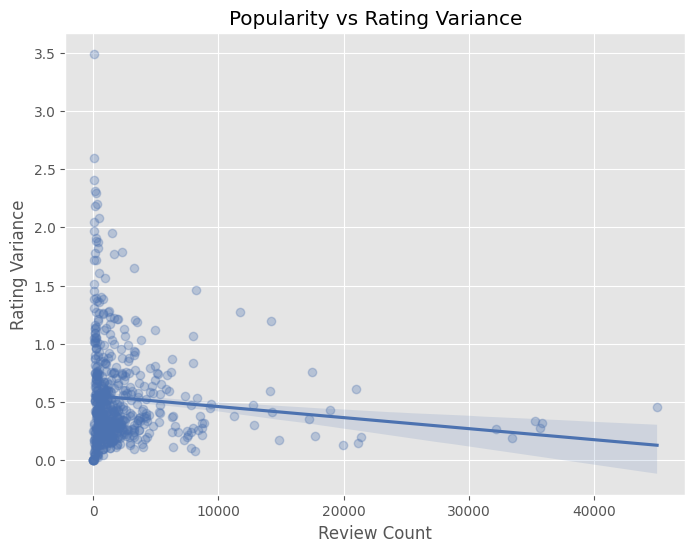

In [100]:
plt.figure(figsize=(8,6))
sns.regplot(data=filtered, x="review_count", y="rating_variance",
            scatter_kws={"alpha":0.3})
plt.title("Popularity vs Rating Variance")
plt.xlabel("Review Count")
plt.ylabel("Rating Variance")
plt.savefig("site/assets/popularity_variance.png", dpi=300, bbox_inches="tight")
plt.show()

# NLP Cleaning Function

In [52]:
stop = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www.\S+", "", text)
    text = re.sub(r"[^a-zA-Z ]", " ", text)
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop]
    return " ".join(words)

df["clean_review"] = df["reviews"].apply(clean_text)
df.head()

,reviews,reviewers,date_reviews,rating,course_id,name,institution,course_url,clean_review
0,"Pretty dry, but I was able to pass with just t...",By Robert S,2020-02-12,4,google-cbrs-cpi-training,Become a CBRS Certified Professional Installer...,Google - Spectrum Sharing,https://www.coursera.org/learn/google-cbrs-cpi...,pretty dry able pas two complete watch happy u...
1,would be a better experience if the video and ...,By Gabriel E R,2020-09-28,4,google-cbrs-cpi-training,Become a CBRS Certified Professional Installer...,Google - Spectrum Sharing,https://www.coursera.org/learn/google-cbrs-cpi...,would better experience video screen shot woul...
2,Information was perfect! The program itself wa...,By Jacob D,2020-04-08,4,google-cbrs-cpi-training,Become a CBRS Certified Professional Installer...,Google - Spectrum Sharing,https://www.coursera.org/learn/google-cbrs-cpi...,information perfect program little annoying wa...
3,A few grammatical mistakes on test made me do ...,By Dale B,2020-02-24,4,google-cbrs-cpi-training,Become a CBRS Certified Professional Installer...,Google - Spectrum Sharing,https://www.coursera.org/learn/google-cbrs-cpi...,grammatical mistake test made double take bad
4,Excellent course and the training provided was...,By Sean G,2020-06-18,4,google-cbrs-cpi-training,Become a CBRS Certified Professional Installer...,Google - Spectrum Sharing,https://www.coursera.org/learn/google-cbrs-cpi...,excellent course training provided detailed ea...


# Time-Based Trend Analysis

In [56]:
# Convert date to year-month
df['year_month'] = df['date_reviews'].dt.to_period('M')
df.head()

,reviews,reviewers,date_reviews,rating,course_id,name,institution,course_url,clean_review,year_month
0,"Pretty dry, but I was able to pass with just t...",By Robert S,2020-02-12,4,google-cbrs-cpi-training,Become a CBRS Certified Professional Installer...,Google - Spectrum Sharing,https://www.coursera.org/learn/google-cbrs-cpi...,pretty dry able pas two complete watch happy u...,2020-02
1,would be a better experience if the video and ...,By Gabriel E R,2020-09-28,4,google-cbrs-cpi-training,Become a CBRS Certified Professional Installer...,Google - Spectrum Sharing,https://www.coursera.org/learn/google-cbrs-cpi...,would better experience video screen shot woul...,2020-09
2,Information was perfect! The program itself wa...,By Jacob D,2020-04-08,4,google-cbrs-cpi-training,Become a CBRS Certified Professional Installer...,Google - Spectrum Sharing,https://www.coursera.org/learn/google-cbrs-cpi...,information perfect program little annoying wa...,2020-04
3,A few grammatical mistakes on test made me do ...,By Dale B,2020-02-24,4,google-cbrs-cpi-training,Become a CBRS Certified Professional Installer...,Google - Spectrum Sharing,https://www.coursera.org/learn/google-cbrs-cpi...,grammatical mistake test made double take bad,2020-02
4,Excellent course and the training provided was...,By Sean G,2020-06-18,4,google-cbrs-cpi-training,Become a CBRS Certified Professional Installer...,Google - Spectrum Sharing,https://www.coursera.org/learn/google-cbrs-cpi...,excellent course training provided detailed ea...,2020-06


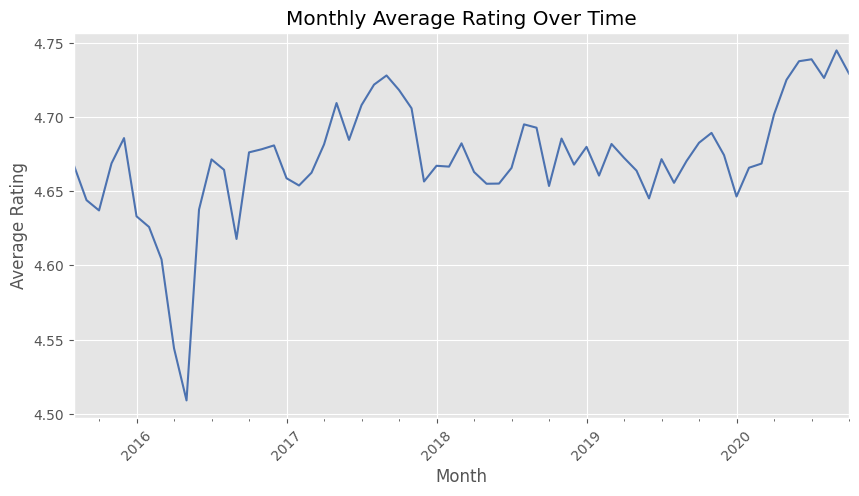

In [101]:
# Monthly Average Rating
monthly = df.groupby("year_month")["rating"].mean()

plt.figure(figsize=(10,5))
monthly.plot(kind="line")
plt.title("Monthly Average Rating Over Time")
plt.ylabel("Average Rating")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.savefig("site/assets/monthly_rating.png", dpi=300, bbox_inches="tight")
plt.show()

# Institution-Level Insights

In [58]:
# Compute institution-level stats
inst_stats = df.groupby("institution").agg(
    avg_rating=("rating", "mean"),
    review_count=("rating", "count")
).reset_index()

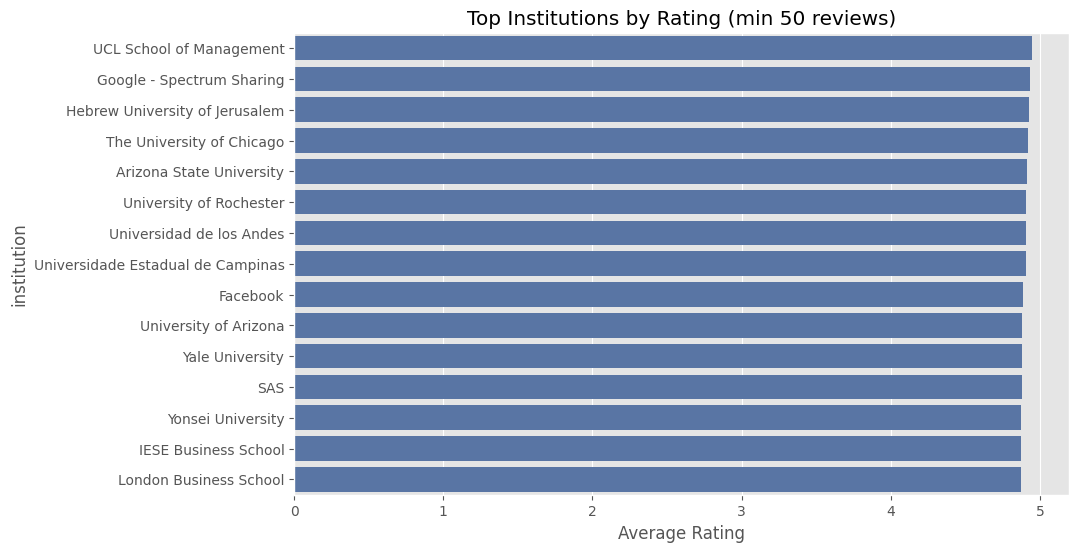

In [102]:
# Top institutions by rating (min 50 reviews)
top_inst = inst_stats[inst_stats["review_count"] >= 50].sort_values("avg_rating", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=top_inst.head(15), x="avg_rating", y="institution")
plt.title("Top Institutions by Rating (min 50 reviews)")
plt.xlabel("Average Rating")
plt.savefig("site/assets/top_institutions.png", dpi=300, bbox_inches="tight")
plt.show()

# Sentiment Analysis

In [60]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [61]:
df["sentiment"] = df["clean_review"].apply(lambda x: analyzer.polarity_scores(x)["compound"])
df[["clean_review","sentiment"]].head()

,clean_review,sentiment
0,pretty dry able pas two complete watch happy u...,0.8834
1,would better experience video screen shot woul...,0.4404
2,information perfect program little annoying wa...,0.7178
3,grammatical mistake test made double take bad,-0.7096
4,excellent course training provided detailed ea...,0.7650


## Sentiment vs Rating Plot

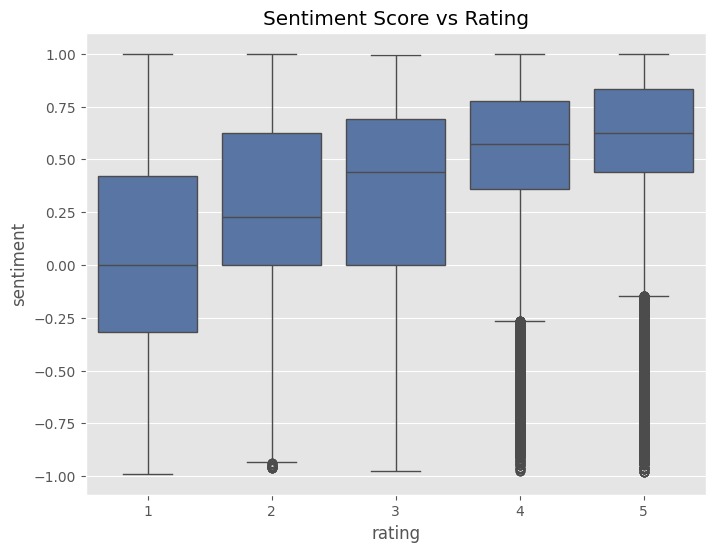

In [103]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x="rating", y="sentiment")
plt.title("Sentiment Score vs Rating")
plt.savefig("site/assets/sentiment_boxplot.png", dpi=300, bbox_inches="tight")
plt.show()

# Word Clouds

In [63]:
from wordcloud import WordCloud

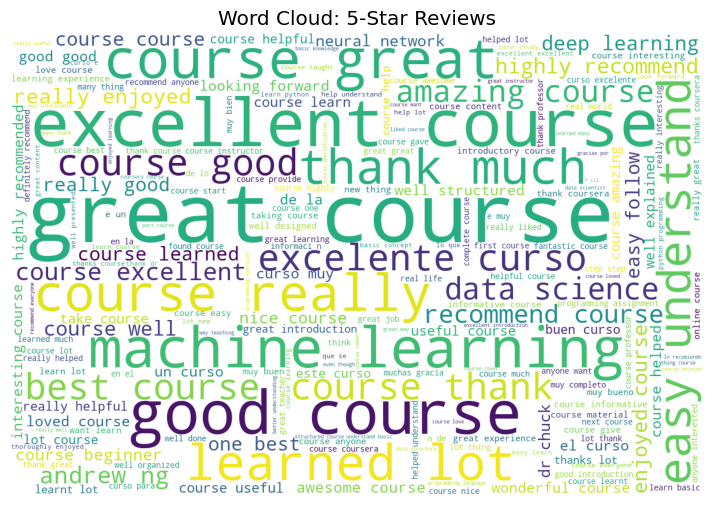

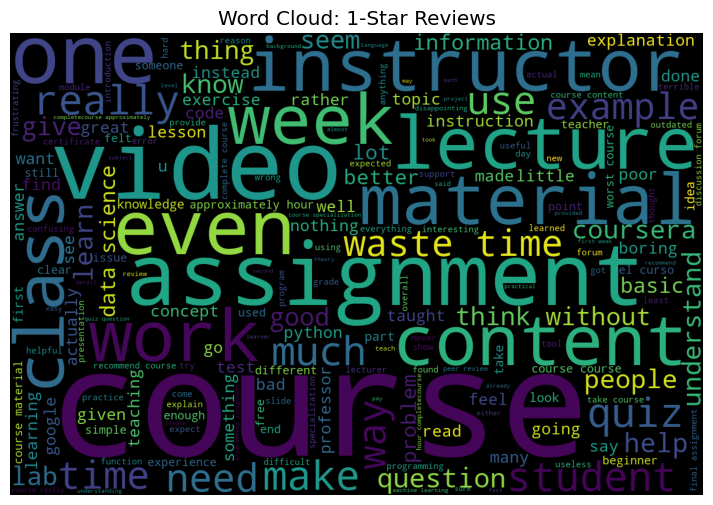

In [104]:
five_star = " ".join(df[df["rating"] == 5]["clean_review"])
one_star = " ".join(df[df["rating"] == 1]["clean_review"])

wc5 = WordCloud(width=1200, height=800, background_color="white").generate(five_star)
wc1 = WordCloud(width=1200, height=800, background_color="black").generate(one_star)

plt.figure(figsize=(12,6))
plt.imshow(wc5)
plt.title("Word Cloud: 5-Star Reviews")
plt.axis("off")
plt.savefig("site/assets/wordcloud_5star.png", dpi=300, bbox_inches="tight")
plt.show()

plt.figure(figsize=(12,6))
plt.imshow(wc1)
plt.title("Word Cloud: 1-Star Reviews")
plt.axis("off")
plt.savefig("site/assets/wordcloud_1star.png", dpi=300, bbox_inches="tight")
plt.show()

# TF-IDF Keyword Extraction

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [66]:
# High-rated and low-rated subsets
high_reviews = df[df["rating"] >= 4]["clean_review"]
low_reviews  = df[df["rating"] <= 2]["clean_review"]

In [67]:
# TF-IDF Function
def extract_keywords(corpus, n_terms=20):
    vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
    X = vectorizer.fit_transform(corpus)
    scores = zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1)
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    return sorted_scores[:n_terms]

In [70]:
print("High-rated keywords:")
extract_keywords(high_reviews)

High-rated keywords:


[('course', np.float64(114498.23560030528)),
 ('good', np.float64(77998.73038510367)),
 ('great', np.float64(67646.67387635405)),
 ('excellent', np.float64(44955.63148574729)),
 ('really', np.float64(31409.04108854867)),
 ('thank', np.float64(30501.98936855663)),
 ('learning', np.float64(28073.545984861707)),
 ('lot', np.float64(26305.820724945042)),
 ('nice', np.float64(24151.16705333936)),
 ('learn', np.float64(22921.95230725703)),
 ('useful', np.float64(22488.25198453957)),
 ('amazing', np.float64(21182.223203652236)),
 ('interesting', np.float64(20685.28015612286)),
 ('thanks', np.float64(20513.436593389586)),
 ('helpful', np.float64(20172.310928371797)),
 ('easy', np.float64(19194.696788028094)),
 ('best', np.float64(18792.759381072174)),
 ('awesome', np.float64(18179.251114194398)),
 ('learned', np.float64(17552.110799850077)),
 ('beginner', np.float64(17116.339737626466))]

In [71]:
print("\nLow-rated keywords:")
extract_keywords(low_reviews)


Low-rated keywords:


[('course', np.float64(2205.442376428485)),
 ('assignment', np.float64(848.7744199183335)),
 ('video', np.float64(788.4612707879764)),
 ('good', np.float64(725.4447323052965)),
 ('time', np.float64(630.2644258495554)),
 ('content', np.float64(598.4986628610342)),
 ('basic', np.float64(578.647869328203)),
 ('like', np.float64(541.6745591014254)),
 ('week', np.float64(541.0040754981811)),
 ('material', np.float64(540.3401102008335)),
 ('really', np.float64(534.3886931321914)),
 ('quiz', np.float64(506.32100920889053)),
 ('lecture', np.float64(495.8001084468625)),
 ('lot', np.float64(469.5759307263211)),
 ('need', np.float64(436.10009357228387)),
 ('learn', np.float64(409.9463812516939)),
 ('way', np.float64(397.3350862952184)),
 ('boring', np.float64(391.8420522742607)),
 ('understand', np.float64(389.2404239054061)),
 ('instructor', np.float64(388.53387569309484))]

# Topic Modeling

In [73]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [89]:
sample_df = df.sample(500000, random_state=12)

vectorizer = CountVectorizer(stop_words="english", max_features=3000)
X = vectorizer.fit_transform(sample_df["clean_review"])
X.shape

(500000, 3000)

## LDA

In [90]:
lda = LatentDirichletAllocation(
    n_components=5,
    learning_method="online",
    random_state=12
)
lda.fit(X)

,n_components,5
,doc_topic_prior,None
,topic_word_prior,None
,learning_method,'online'
,learning_decay,0.7
,learning_offset,10.0
,max_iter,10
,batch_size,128
,evaluate_every,-1
,total_samples,1000000.0
,perp_tol,0.1


## Show topics

In [91]:
words = vectorizer.get_feature_names_out()

for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx}:")
    print([words[i] for i in topic.argsort()[-15:]])

Topic 0:
['field', 'different', 'real', 'tool', 'feel', 'world', 'love', 'practical', 'great', 'science', 'introduction', 'nice', 'data', 'excellent', 'course']
Topic 1:
['problem', 'think', 'little', 'bit', 'exercise', 'like', 'content', 'quiz', 'week', 'example', 'material', 'lecture', 'time', 'video', 'assignment']
Topic 2:
['clear', 'learn', 'programming', 'really', 'beginner', 'recommend', 'python', 'great', 'concept', 'basic', 'easy', 'understand', 'learning', 'good', 'course']
Topic 3:
['enjoyed', 'interesting', 'best', 'coursera', 'professor', 'amazing', 'learning', 'learn', 'learned', 'thanks', 'really', 'thank', 'lot', 'great', 'course']
Topic 4:
['buen', 'una', 'gracias', 'por', 'se', 'lo', 'los', 'excelente', 'para', 'el', 'en', 'muy', 'que', 'la', 'curso']


# Polarization/Popularity Statistics

In [92]:
corr1 = filtered["review_count"].corr(filtered["avg_rating"])
corr2 = filtered["review_count"].corr(filtered["rating_variance"])
corr1, corr2

(np.float64(0.08758484020690288), np.float64(-0.09986532502318539))

In [93]:
# To export to PNG
plt.savefig("site/assets/rating_distribution.png", dpi=300, bbox_inches="tight")